In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 下載股票數據
def download_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data[['Close']]

# 資料預處理
def preprocess_data(data, time_step=60):
    data_values = data.values
    x_data, y_data = [], []
    for i in range(time_step, len(data_values)):
        x_data.append(data_values[i-time_step:i, 0])
        y_data.append(data_values[i, 0])
    
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    
    # 切分訓練集和測試集
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
    
    # 將數據轉換為 PyTorch 的 Tensor，並傳到 GPU
    x_train = torch.from_numpy(x_train).float().to(device)
    y_train = torch.from_numpy(y_train).float().to(device)
    x_test = torch.from_numpy(x_test).float().to(device)
    y_test = torch.from_numpy(y_test).float().to(device)
    
    return x_train, y_train, x_test, y_test

In [4]:
# 定義 Transformer 模型
class TransformerStockPredictor(nn.Module):
    def __init__(self, input_dim=1, embed_dim=64, num_heads=4, num_layers=2, forward_dim=128, output_dim=1, dropout=0.1):
        super(TransformerStockPredictor, self).__init__()
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        self.position_encoding = nn.Parameter(torch.zeros(1, 500, embed_dim))  # Position encoding with a max sequence length of 500
        self.transformer_layers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=forward_dim, dropout=dropout),
            num_layers=num_layers
        )
        self.fc_out = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        # Embed and add positional encoding
        x = self.input_embedding(x.unsqueeze(-1)) + self.position_encoding[:, :x.size(1), :]
        x = self.transformer_layers(x)
        return self.fc_out(x[:, -1])  # 只取最後一個時間步的輸出

In [5]:
# 訓練模型
def train_model(model, x_train, y_train, x_test, y_test, epochs=100, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = criterion(y_pred.squeeze(), y_train)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

        # 評估模型
        model.eval()
        with torch.no_grad():
            test_pred = model(x_test)
            test_loss = criterion(test_pred.squeeze(), y_test)
            test_losses.append(test_loss.item())
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Train Loss: {loss.item()}, Test Loss: {test_loss.item()}")
    
    return train_losses, test_losses

# 繪製結果
def plot_predictions(model, x_train, y_train, x_test, y_test, date_train, date_test):
    model.eval()
    with torch.no_grad():
        train_pred = model(x_train).squeeze().cpu().numpy()
        test_pred = model(x_test).squeeze().cpu().numpy()
    
    plt.figure(figsize=(16,8))
    plt.title('Stock Price Prediction using LSTM (PyTorch)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    
    # 繪製訓練資料的實際值和預測值
    plt.plot(date_train, y_train.cpu(), label='Train Data')
    plt.plot(date_test, y_test.cpu(), label='Test Data')
    plt.plot(date_test, test_pred, label='Predictions')
    
    plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
    plt.show()

In [9]:
ticker = '2330.TW'
start_date = '2018-01-01'
end_date = '2024-03-01'
time_step = 60  # 自訂時間窗格

data = download_stock_data(ticker, start_date, end_date)
data = data.dropna()
x_train, y_train, x_test, y_test = preprocess_data(data, time_step)
train_size = len(y_train)

date_train = data.index[:train_size]
date_test = data.index[train_size:-(time_step)]

[*********************100%***********************]  1 of 1 completed


In [7]:
# 初始化和訓練模型，並將模型轉移到 GPU
model = TransformerStockPredictor().to(device)
train_losses, test_losses = train_model(model, x_train, y_train, x_test, y_test, epochs=10000)

Epoch 0, Train Loss: 187088.828125, Test Loss: 304292.0625
Epoch 10, Train Loss: 183783.0625, Test Loss: 300482.53125
Epoch 20, Train Loss: 183088.296875, Test Loss: 299595.78125
Epoch 30, Train Loss: 182504.5, Test Loss: 298799.625
Epoch 40, Train Loss: 181894.03125, Test Loss: 297965.9375
Epoch 50, Train Loss: 181250.09375, Test Loss: 297077.3125
Epoch 60, Train Loss: 180563.71875, Test Loss: 296131.1875
Epoch 70, Train Loss: 179832.53125, Test Loss: 295123.0625
Epoch 80, Train Loss: 179058.0, Test Loss: 294054.46875
Epoch 90, Train Loss: 178239.15625, Test Loss: 292924.25
Epoch 100, Train Loss: 177375.140625, Test Loss: 291732.71875
Epoch 110, Train Loss: 176466.9375, Test Loss: 290480.9375
Epoch 120, Train Loss: 175516.515625, Test Loss: 289168.96875
Epoch 130, Train Loss: 174523.0, Test Loss: 287797.875
Epoch 140, Train Loss: 173491.1875, Test Loss: 286369.65625
Epoch 150, Train Loss: 172417.703125, Test Loss: 284883.40625
Epoch 160, Train Loss: 171299.4375, Test Loss: 283340.1562

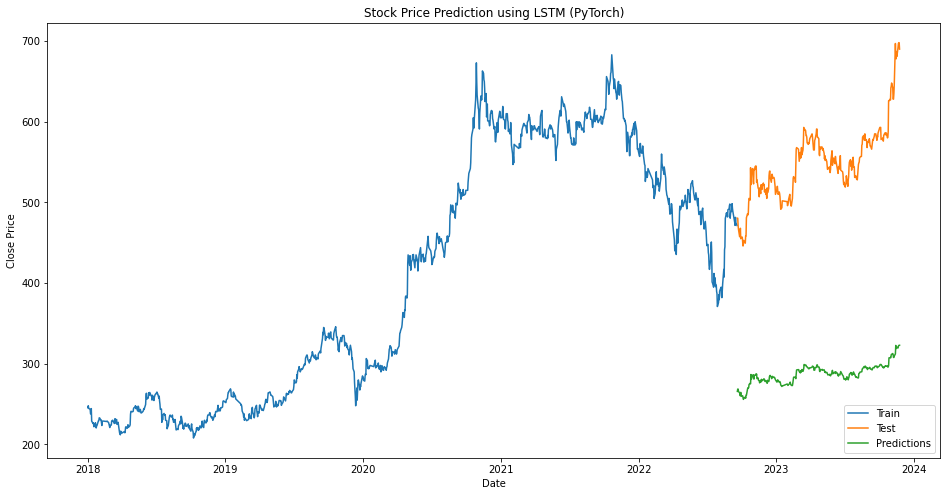

In [10]:
# 繪製結果
plot_predictions(model, x_train, y_train, x_test, y_test, date_train, date_test)